In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import Image,display
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets,transforms
import torchvision.models as models
from skimage.color import rgb2lab,lab2rgb,rgb2gray
from skimage import io
import time
from google.colab.patches import cv2_imshow
from PIL import Image
import random

In [3]:
#path = '/content/drive/My Drive/Train'

In [4]:
#!mkdir newfolder

In [5]:
!unzip '/content/drive/My Drive/archive.zip' -d '/content/'

Streaming output truncated to the last 5000 lines.
  inflating: /content/archive/Places365_val_00009571.jpg  
  inflating: /content/archive/Places365_val_00009572.jpg  
  inflating: /content/archive/Places365_val_00009573.jpg  
  inflating: /content/archive/Places365_val_00009574.jpg  
  inflating: /content/archive/Places365_val_00009575.jpg  
  inflating: /content/archive/Places365_val_00009576.jpg  
  inflating: /content/archive/Places365_val_00009577.jpg  
  inflating: /content/archive/Places365_val_00009578.jpg  
  inflating: /content/archive/Places365_val_00009579.jpg  
  inflating: /content/archive/Places365_val_00009580.jpg  
  inflating: /content/archive/Places365_val_00009581.jpg  
  inflating: /content/archive/Places365_val_00009582.jpg  
  inflating: /content/archive/Places365_val_00009583.jpg  
  inflating: /content/archive/Places365_val_00009584.jpg  
  inflating: /content/archive/Places365_val_00009585.jpg  
  inflating: /content/archive/Places365_val_00009586.jpg  
  inf

In [6]:
#!wget http://data.csail.mit.edu/places/places205/testSetPlaces205_resize.tar.gz
#!tar -xzf testSetPlaces205_resize.tar.gz

In [7]:
l = list(os.listdir('/content/archive'))

In [8]:
len(l)

22062

In [9]:
random.shuffle(l)

In [10]:
os.makedirs('/content/train/class/', exist_ok=True)
os.makedirs('/content/val/class/',exist_ok=True)
c = 0
for name in l:
  if c<1000:
    os.rename('/content/archive/'+name,'/content/val/class/'+name)
    c+=1
  else:
    os.rename('/content/archive/'+name,'/content/train/class/'+name)
    c+=1

In [11]:
#os.makedirs('/content/train/class/', exist_ok=True)
#os.makedirs('/content/val/class/',exist_ok=True)
#for i, file in enumerate(os.listdir('/content/testSet_resize')):
  #if i < 1000: # first 1000 will be val
    #os.rename('/content/testSet_resize/' + file, '/content/val/class/' + file)
  #else: # others will be val
    #os.rename('/content/testSet_resize/' + file, '/content/train/class/' + file)

In [12]:
#vgg = models.resnet18(pretrained=True)

In [13]:
#first_conv_layer = [nn.Conv2d(1, 3, kernel_size=3, stride=1, padding=1),nn.ReLU(inplace=True) ]
#first_conv_layer.extend(list(vgg.features))  
#vgg.features= nn.Sequential(*first_conv_layer ) 

In [14]:
#vgg

In [15]:
#list(vgg.children())[0:6]

In [16]:
use_gpu = torch.cuda.is_available()

In [17]:
class ColorizationNet(nn.Module):
  def __init__(self, input_size=128):
    super(ColorizationNet, self).__init__()
    MIDLEVEL_FEATURE_SIZE = 128

    ## First half: ResNet
    resnet = models.resnet18(num_classes=365) 
    # Change first conv layer to accept single-channel (grayscale) input
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(0))
    resnet.conv1 = nn.Conv2d(1,64,kernel_size=(3,3),stride = (1,1),padding=(1,1))
    # Extract midlevel features from ResNet-gray
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

   ## Second half: Upsampling
    self.upsample = nn.Sequential(     
      nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      #nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2)
    )

  def forward(self, input):

    # Pass input through ResNet-gray to extract features
    midlevel_features = self.midlevel_resnet(input)

    # Upsample to get colors
    output = self.upsample(midlevel_features)
    return output

In [18]:
model = ColorizationNet()

In [19]:
criterion = nn.MSELoss()

In [20]:
optimizer = torch.optim.Adam(model.parameters(),lr=1e-2)

In [21]:
class GrayscaleImageFolder(datasets.ImageFolder):
  '''Custom images folder, which converts images to grayscale before loading'''
  def __getitem__(self, index):
    path, target = self.imgs[index]
    img = self.loader(path)
    if self.transform is not None:
      img_original = self.transform(img)
      img_original = np.asarray(img_original)
      img_lab = rgb2lab(img_original)
      img_lab = (img_lab + 128) / 255
      img_ab = img_lab[:, :, 1:3]
      img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
      img_original = rgb2gray(img_original)
      img_original = torch.from_numpy(img_original).unsqueeze(0).float()
    if self.target_transform is not None:
      target = self.target_transform(target)
    return img_original, img_ab, target

In [22]:
train_tranforms = transforms.Compose([transforms.Resize(224),transforms.RandomSizedCrop(224),transforms.RandomHorizontalFlip()])
train_imagefolder = GrayscaleImageFolder('/content/train',train_tranforms)
train_loader = torch.utils.data.DataLoader(train_imagefolder,batch_size=64,shuffle=True)
val_transforms = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224)])
val_imagefolder = GrayscaleImageFolder('/content/val',val_transforms)
val_loader = torch.utils.data.DataLoader(val_imagefolder,batch_size=64,shuffle=True)

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:841: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  "please use transforms.RandomResizedCrop instead.")


In [23]:
class AverageMeter(object):
  '''A handy class from the PyTorch ImageNet tutorial''' 
  def __init__(self):
    self.reset()
  def reset(self):
    self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

In [34]:
def to_rgb(grayscale_input, ab_input, save_path=None, save_name=None):
  '''Show/save rgb image from grayscale and ab channels
     Input save_path in the form {'grayscale': '/path/', 'colorized': '/path/'}'''
  plt.clf() # clear matplotlib 
  color_image = torch.cat((grayscale_input, ab_input), 0).numpy() # combine channels
  color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
  color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
  color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
  color_image = lab2rgb(color_image.astype(np.float64))
  grayscale_input = grayscale_input.squeeze().numpy()
  if save_path is not None and save_name is not None: 
    plt.imsave(arr=grayscale_input, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
    plt.imsave(arr=color_image, fname='{}{}'.format(save_path['colorized'], save_name))

In [24]:
def validate(val_loader, model, criterion, save_images, epoch):
  model.eval()

  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  already_saved_images = False
  for i, (input_gray, input_ab, target) in enumerate(val_loader):
    data_time.update(time.time() - end)

    # Use GPU
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Run model and record loss
    output_ab = model(input_gray) # throw away class predictions
    loss = criterion(output_ab, input_ab)
    losses.update(loss.item(), input_gray.size(0))

    # Save images to file
    if save_images and not already_saved_images:
      already_saved_images = True
      for j in range(min(len(output_ab), 10)): # save at most 5 images
        save_path = {'grayscale': 'outputs/gray/', 'colorized': 'outputs/color/'}
        save_name = 'img-{}-epoch-{}.jpg'.format(i * val_loader.batch_size + j, epoch)
        to_rgb(input_gray[j].cpu(), ab_input=output_ab[j].detach().cpu(), save_path=save_path, save_name=save_name)

    # Record time to do forward passes and save images
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to both value and validation
    if i % 25 == 0:
      print('Validate: [{0}/{1}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
             i, len(val_loader), batch_time=batch_time, loss=losses))

  print('Finished validation.')
  return losses.avg

In [25]:
def train(train_loader, model, criterion, optimizer, epoch):
  print('Starting training epoch {}'.format(epoch))
  model.train()
  
  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  for i, (input_gray, input_ab, target) in enumerate(train_loader):
    
    # Use GPU if available
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Record time to load data (above)
    data_time.update(time.time() - end)

    # Run forward pass
    output_ab = model(input_gray) 
    loss = criterion(output_ab, input_ab) 
    losses.update(loss.item(), input_gray.size(0))

    # Compute gradient and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Record time to do forward and backward passes
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to value, not validation
    if i % 25 == 0:
      print('Epoch: [{0}][{1}/{2}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
              epoch, i, len(train_loader), batch_time=batch_time,
             data_time=data_time, loss=losses)) 

  print('Finished training epoch {}'.format(epoch))

In [26]:
model.load_state_dict(torch.load('/content/model-epoch-10-losses-0.003.pth'))

<All keys matched successfully>

In [27]:
if use_gpu:
  criterion = criterion.cuda()
  model = model.cuda()

In [28]:
os.makedirs('/content/outputs/color', exist_ok=True)
os.makedirs('/content/outputs/gray', exist_ok=True)
os.makedirs('/content/checkpoints', exist_ok=True)
save_images = True
best_losses = 1e10
epochs = 50 

In [29]:
#a = 'midlevel_resnet'

In [30]:
#params = list(model.state_dict().keys())
#params = [x for x in params if a in x ]

In [31]:
#for name,param in model.named_parameters():
  #if param.requires_grad and a in name:
    #param.requires_grad = False

In [ ]:
for epoch in range(epochs):
  train(train_loader,model,criterion,optimizer,epoch)
  with torch.no_grad():
    loss = validate(val_loader,model,criterion,save_images,epoch)
    torch.save(model.state_dict(), '/content/drive/My Drive/checkpoints/model-epoch-{}-losses-{:.3f}.pth'.format(epoch+1,loss))

Starting training epoch 0
Epoch: [0][0/330]	Time 1.838 (1.838)	Data 1.548 (1.548)	Loss 0.0024 (0.0024)	
Epoch: [0][25/330]	Time 1.622 (1.730)	Data 1.380 (1.485)	Loss 0.0024 (0.0024)	
Epoch: [0][50/330]	Time 1.732 (1.723)	Data 1.489 (1.479)	Loss 0.0022 (0.0025)	
Epoch: [0][75/330]	Time 1.623 (1.699)	Data 1.380 (1.455)	Loss 0.0026 (0.0025)	
Epoch: [0][100/330]	Time 1.734 (1.685)	Data 1.492 (1.442)	Loss 0.0024 (0.0025)	
Epoch: [0][125/330]	Time 1.612 (1.677)	Data 1.369 (1.434)	Loss 0.0021 (0.0025)	
Epoch: [0][150/330]	Time 1.656 (1.671)	Data 1.414 (1.427)	Loss 0.0022 (0.0025)	
Epoch: [0][175/330]	Time 1.611 (1.668)	Data 1.370 (1.424)	Loss 0.0022 (0.0025)	
Epoch: [0][200/330]	Time 1.666 (1.664)	Data 1.425 (1.421)	Loss 0.0034 (0.0025)	
Epoch: [0][225/330]	Time 1.625 (1.661)	Data 1.383 (1.418)	Loss 0.0023 (0.0025)	
Epoch: [0][250/330]	Time 1.693 (1.659)	Data 1.449 (1.416)	Loss 0.0026 (0.0025)	
Epoch: [0][275/330]	Time 1.634 (1.656)	Data 1.392 (1.413)	Loss 0.0025 (0.0024)	
Epoch: [0][300/330]

In [ ]:
       # Show images 
import matplotlib.image as mpimg
image_pairs = [('outputs/color/img-8-epoch-0.jpg', 'outputs/gray/img-8-epoch-0.jpg'),
               ('outputs/color/img-4-epoch-0.jpg', 'outputs/gray/img-4-epoch-0.jpg')]
for c, g in image_pairs:
  color = mpimg.imread(c)
  gray  = mpimg.imread(g)
  f, axarr = plt.subplots(1, 2)
  f.set_size_inches(15, 15)
  axarr[0].imshow(gray, cmap='gray')
  axarr[1].imshow(color)
  axarr[0].axis('off'), axarr[1].axis('off')
  plt.show() 

IndentationError: ignored

In [ ]:
t_img = Image.open('/content/images.jpg')
img = val_transforms(t_img)
img = np.array(img)
gr = rgb2gray(img)
gr = torch.from_numpy(gr)
gr = gr.reshape(gr.shape+(1,))
gr = gr.permute((2,0,1))
gr = gr.unsqueeze(dim=0)
gr = gr.type(torch.FloatTensor)
gr = gr.cuda()
model.eval()
output = model(gr)
Img = np.squeeze(output)
gr = np.squeeze(gr)
gr = gr.reshape((1,)+gr.shape)

In [ ]:
def to_rgb_out(grayscale_input, ab_input):
  '''Show/save rgb image from grayscale and ab channels
     Input save_path in the form {'grayscale': '/path/', 'colorized': '/path/'}'''
  plt.clf() # clear matplotlib 
  color_image = torch.cat((grayscale_input, ab_input), 0).detach().numpy() # combine channels
  color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
  color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
  color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
  color_image = lab2rgb(color_image.astype(np.float64))
  grayscale_input = grayscale_input.squeeze().numpy()
  return grayscale_input,color_image 

In [ ]:
gray_img,out_img = to_rgb_out(gr.cpu(),Img.cpu())

<Figure size 432x288 with 0 Axes>

In [ ]:
out_img.dtype

dtype('float64')

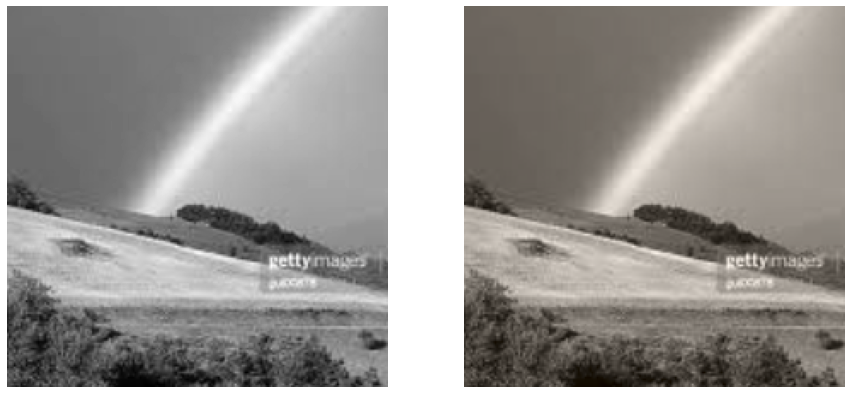

In [ ]:
f, axarr = plt.subplots(1, 2)
f.set_size_inches(15, 15)
axarr[0].imshow(gray_img, cmap='gray')
axarr[1].imshow(out_img)
axarr[0].axis('off'), axarr[1].axis('off')
plt.show()

In [ ]:
!nvidia-smi

Wed Nov 11 16:55:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!wget https://www.dropbox.com/s/kz76e7gv2ivmu8p/model-epoch-93.pth

--2020-11-10 05:19:57--  https://www.dropbox.com/s/kz76e7gv2ivmu8p/model-epoch-93.pth
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.1, 2620:100:601c:1::a27d:601
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/kz76e7gv2ivmu8p/model-epoch-93.pth [following]
--2020-11-10 05:19:57--  https://www.dropbox.com/s/raw/kz76e7gv2ivmu8p/model-epoch-93.pth
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 404 Not Found
2020-11-10 05:19:57 ERROR 404: Not Found.

